In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
import re
import numpy as np

# from sklearn.surprise import Dataset, Reader
# from surprise.model_selection import train_test_split
# from surprise import SVD

In [20]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [21]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Cleaning

In [22]:
# Checking and removing NaNs

movies_nan = movies.isna().sum()
ratings_nan = ratings.isna().sum()
tags_nan = tags.isna().sum()
links_nan = links.isna().sum()
print("NaN counts in movies:\n", movies_nan)
print("\nNaN counts in ratings:\n", ratings_nan)
print("\nNaN counts in tags:\n", tags_nan)
print("\nNaN counts in links:\n", links_nan)

# TMDB ID the only column with NaNs
links['tmdbId'].fillna('Unknown', inplace=True)




NaN counts in movies:
 movieId    0
title      0
genres     0
dtype: int64

NaN counts in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

NaN counts in tags:
 userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

NaN counts in links:
 movieId    0
imdbId     0
tmdbId     8
dtype: int64


C:\Users\betht\AppData\Local\Temp\ipykernel_15328\166927940.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  links['tmdbId'].fillna('Unknown', inplace=True)


In [23]:
# Removing duplicates
ratings.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
tags.drop_duplicates(subset=['userId', 'movieId', 'tag'], inplace=True)

# Data type conversion
movies['movieId'] = movies['movieId'].astype(int)
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)

# Standardizing text
movies['title'] = movies['title'].str.lower()
tags['tag'] = tags['tag'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x).lower())

movies['genres'] = movies['genres'].str.split('|')

# Assuming the 'timestamp' column is in your 'ratings' DataFrame
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')




## Data Merging

In [24]:
movie_ratings = pd.merge(movies, ratings, on='movieId')
movie_ratings_tags = pd.merge(movie_ratings, tags, on=['movieId', 'userId'], how='left')
final_dataset = pd.merge(movie_ratings_tags, links, on='movieId', how='left')
final_dataset.head()

,movieId,title,genres,userId,rating,timestamp_x,tag,timestamp_y,imdbId,tmdbId
0,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,2000-07-30 18:45:03,NaN,NaT,114709,862.0
1,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1996-11-08 06:36:02,NaN,NaT,114709,862.0
2,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,2005-01-25 06:52:26,NaN,NaT,114709,862.0
3,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,2017-11-13 12:59:30,NaN,NaT,114709,862.0
4,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,2011-05-18 05:28:03,NaN,NaT,114709,862.0


In [25]:
final_dataset_nan = final_dataset.isna().sum()
print("NaN counts in movies:\n", final_dataset_nan)
# Counting non-NaN values in the 'tag' column
non_nan_count_tag = final_dataset['tag'].notna().sum()

# Displaying the count
print("Number of non-NaN values in 'tag':", non_nan_count_tag)
# Counting non-NaN values in the 'tag' column
non_nan_count_timestamp_y = final_dataset['timestamp_y'].notna().sum()

# Displaying the count
print("Number of non-NaN values in 'timestamp_y':", non_nan_count_timestamp_y)

# Fill NaN values in 'tag' with 'No Tag'
final_dataset['tag'].fillna('No Tag', inplace=True)

# Drop 'timestamp_y' if not needed
final_dataset.drop(columns=['timestamp_y'], inplace=True)

final_dataset = final_dataset.rename(columns={'timestamp_x': 'timestamp'})


final_dataset.head()

NaN counts in movies:
 movieId            0
title              0
genres             0
userId             0
rating             0
timestamp_x        0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId             0
dtype: int64
Number of non-NaN values in 'tag': 3476
Number of non-NaN values in 'timestamp_y': 3476


,movieId,title,genres,userId,rating,timestamp,tag,imdbId,tmdbId
0,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,2000-07-30 18:45:03,No Tag,114709,862.0
1,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1996-11-08 06:36:02,No Tag,114709,862.0
2,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,2005-01-25 06:52:26,No Tag,114709,862.0
3,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,2017-11-13 12:59:30,No Tag,114709,862.0
4,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,2011-05-18 05:28:03,No Tag,114709,862.0


## Feature Engineering- Timestamps to reflect trends

In [26]:
from datetime import datetime
import numpy as np

# Adjust the decay factor
decay_factor = 0.99

# Ensure correct conversion of timestamp to datetime
final_dataset['timestamp'] = pd.to_datetime(final_dataset['timestamp'])

# Calculate the age of each rating
current_date = pd.to_datetime('now')
final_dataset['rating_age_days'] = (current_date - final_dataset['timestamp']).dt.days

# Apply the decay function
final_dataset['rating_weight'] = decay_factor ** final_dataset['rating_age_days']

# Calculate the weighted rating score (without dividing by frequency)
weighted_rating_score = final_dataset.groupby('movieId').apply(lambda x: np.mean(x['rating_weight'])).reset_index(name='weighted_rating_score')

# Normalize the scores (optional, can use min-max scaling or z-score standardization)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
weighted_rating_score['normalized_score'] = scaler.fit_transform(weighted_rating_score[['weighted_rating_score']])

# Merge with the main dataset if needed
final_dataset = final_dataset.merge(weighted_rating_score, on='movieId')

# Now, you can use 'normalized_score' as your trending score


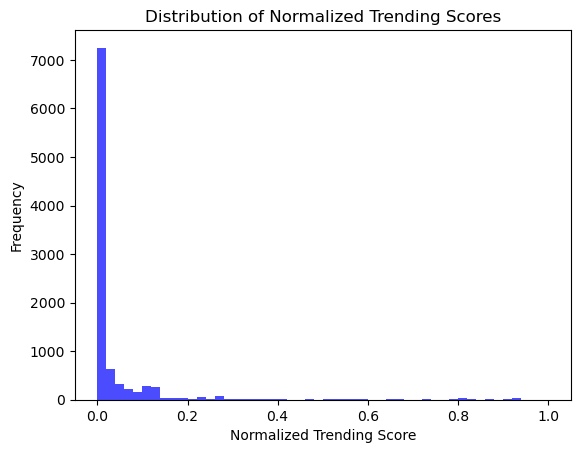

count    102677.000000
mean          0.023188
std           0.051640
min           0.000000
25%           0.000958
50%           0.010688
75%           0.026115
max           1.000000
Name: normalized_score, dtype: float64


In [27]:
import matplotlib.pyplot as plt
normalized_scores = weighted_rating_score['normalized_score']


# Plotting a histogram
plt.hist(normalized_scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Normalized Trending Scores')
plt.xlabel('Normalized Trending Score')
plt.ylabel('Frequency')
plt.show()
highest_normalized_score = final_dataset['normalized_score'].describe()
print(highest_normalized_score)


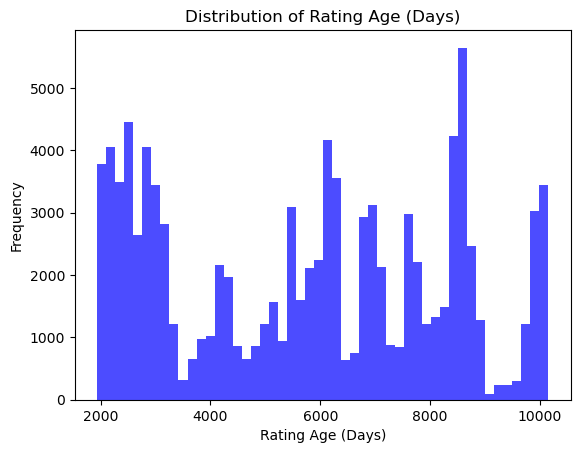

In [28]:
# Check distribution of rating_age_days
plt.hist(final_dataset['rating_age_days'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Rating Age (Days)')
plt.xlabel('Rating Age (Days)')
plt.ylabel('Frequency')
plt.show()




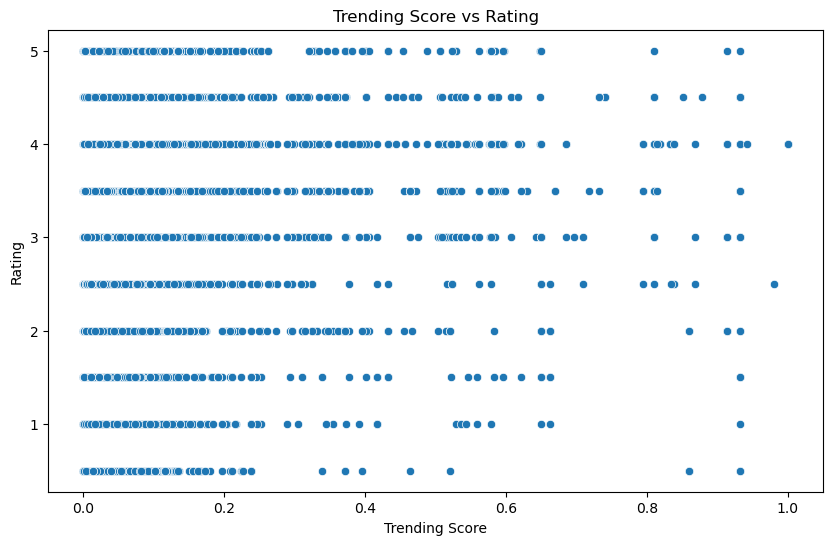

Correlation between Trending Score and Rating: 0.030301329735442972


In [29]:
# Scatter plot of 'trending score' vs 'ratings'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='normalized_score', y='rating', data=final_dataset)
plt.title('Trending Score vs Rating')
plt.xlabel('Trending Score')
plt.ylabel('Rating')
plt.show()

# Calculating the correlation
correlation = final_dataset['normalized_score'].corr(final_dataset['rating'])
print("Correlation between Trending Score and Rating:", correlation)


In [30]:
final_dataset.head()

,movieId,title,genres,userId,rating,timestamp,tag,imdbId,tmdbId,rating_age_days,rating_weight,weighted_rating_score,normalized_score
0,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,2000-07-30 18:45:03,No Tag,114709,862.0,8568,4.002647e-38,5.365459e-11,0.015752
1,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1996-11-08 06:36:02,No Tag,114709,862.0,9929,4.590364e-44,5.365459e-11,0.015752
2,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,2005-01-25 06:52:26,No Tag,114709,862.0,6929,5.705101e-31,5.365459e-11,0.015752
3,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,2017-11-13 12:59:30,No Tag,114709,862.0,2254,1.451205e-10,5.365459e-11,0.015752
4,1,toy story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,2011-05-18 05:28:03,No Tag,114709,862.0,4625,6.497930e-21,5.365459e-11,0.015752


In [31]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate


#Train SVD model using surprise

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(final_dataset[['userId', 'movieId', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8667  0.8696  0.8734  0.8653  0.8534  0.8657  0.0067  
MAE (testset)     0.6618  0.6643  0.6668  0.6620  0.6527  0.6615  0.0048  
Fit time          1.30    1.54    1.40    1.21    1.23    1.34    0.12    
Test time         0.13    0.18    0.14    0.13    0.21    0.16    0.03    


{'test_rmse': array([0.86669007, 0.8696052 , 0.87344344, 0.86534425, 0.85343722]),
 'test_mae': array([0.66180906, 0.66433871, 0.66682537, 0.66201427, 0.65265611]),
 'fit_time': (1.3042850494384766,
  1.5442674160003662,
  1.4017691612243652,
  1.209714651107788,
  1.2300548553466797),
 'test_time': (0.13272428512573242,
  0.18024849891662598,
  0.13719606399536133,
  0.12929177284240723,
  0.21320343017578125)}

In [32]:
#predict ratings for unrated movies


def get_unrated_movies(all_movies, user_rated_movies):
    return all_movies[~all_movies['movieId'].isin(user_rated_movies['movieId'])]

# Example for a specific user
user_id = 1
user_movies = final_dataset[final_dataset['userId'] == user_id]
unrated_movies = get_unrated_movies(final_dataset, user_movies)

predictions = []
for movie_id in unrated_movies['movieId'].unique():
    prediction = svd.predict(user_id, movie_id)
    predictions.append({'movieId': movie_id, 'predicted_rating': prediction.est})

sorted_predictions = sorted(predictions, key=lambda x: x['predicted_rating'], reverse=True)


In [33]:
# Merge predicted ratings with weighted scores
predicted_ratings_df = pd.DataFrame(sorted_predictions)
combined_scores_df = predicted_ratings_df.merge(weighted_rating_score, on='movieId')

# Calculate hybrid score
combined_scores_df['hybrid_score'] = combined_scores_df['predicted_rating'] * combined_scores_df['normalized_score']
combined_scores_df = combined_scores_df.sort_values(by='hybrid_score', ascending=False)
combined_scores_df.head()


,movieId,predicted_rating,weighted_rating_score,normalized_score,hybrid_score
2229,130444,4.366448,3.406258e-09,1.000000,4.366448
4089,179511,4.246780,3.406258e-09,1.000000,4.246780
6358,166203,4.157315,3.406258e-09,1.000000,4.157315
1375,157369,4.443153,3.174855e-09,0.932065,4.141309
1401,172705,4.441233,3.174855e-09,0.932065,4.139519


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combine movie genres into a single string
movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Compute cosine similarity between movies based on genres
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on content
def content_based_recommendations(movie_title):
    idx = movies_df.index[movies_df['title'] == movie_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get the top 10 most similar movies (excluding itself)
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

# Example: Get content-based recommendations for a movie
movie_title = "Toy Story (1995)"
content_based_rec = content_based_recommendations(movie_title)


NameError: name 'movies_df' is not defined

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Combine movie genres into a single string
movies_df['genres'] = movies_df['genres'].str.replace('|', ' ')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['genres'])

# Compute cosine similarity between movies based on genres
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations based on content
def content_based_recommendations(movie_title):
    idx = movies_df.index[movies_df['title'] == movie_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get the top 10 most similar movies (excluding itself)
    movie_indices = [i[0] for i in sim_scores]
    return movies_df['title'].iloc[movie_indices]

# Example: Get content-based recommendations for a movie
movie_title = "Toy Story (1995)"
content_based_rec = content_based_recommendations(movie_title)
